# Single-cell data integration with novosparc

First make sure you have installed spacemake as specified [here](https://spacemake.readthedocs.io/en/latest/install.html#installation).

In spacemake it is possible to integrate `spatial` and `single-cell` data. This is done with the help of [novosparc](https://github.com/rajewsky-lab/novosparc), an optimal transport based approach ([Nitzah, Karaiskos et al. 2019](https://www.nature.com/articles/s41586-019-1773-3),
[Moriel, Senel et al. 2021](https://www.nature.com/articles/s41596-021-00573-7)).

Currently spacemake offers two use cases:

1. Given a `single-cell` data (without `spatial` information) spacemake will use novosparc to reconstruct the tissue.
2. If both `single-cell` and `spatial` data is available, spacemake will use novosparc to map the `single-cell` data onto the `spatial` data, using the expression information of the latter as reference.

Below we present a tutorial for both.

The dataset used here is from [mousebrain.org](https://storage.googleapis.com/linnarsson-lab-loom/l5_all.loom) ([Zeisel et al. 2018](https://linkinghub.elsevier.com/retrieve/pii/S0092-8674(18)30789-X)). We downloaded the `l5_all.loom` file, and then filtered it for the following 'Tissue' values: Thal, CA1, Hypoth, Ctx2, DentGyr, SScortex. Finally, we [processed](https://spacemake.readthedocs.io/en/latest/projects/index.html#add-a-pre-processed-count-matrix) this filtered matrix with spacemake.

## Reconstructing a tissue de-novo with novosparc

To reconstruct a tissue *de-novo* with novosparc, we will use the [spacemake.spatial.novosparc_integration.novosparc_denovo](https://spacemake.readthedocs.io/en/latest/api/api.html#spacemake.spatial.novosparc_integration.novosparc_denovo) function.

First, lets download and decompress the data:

In [1]:
!wget -nv -O zeisel_adata.h5ad.gz http://bimsbstatic.mdc-berlin.de/rajewsky/spacemake-test-data/zeisel_2018/adata.h5ad.gz
!unpigz zeisel_adata.h5ad.gz

2022-04-07 23:59:19 URL:https://bimsbstatic.mdc-berlin.de/rajewsky/spacemake-test-data/zeisel_2018/adata.h5ad.gz [434704805/434704805] -> "zeisel_adata.h5ad.gz" [1]


Then we can load the necessary packages, modules and load the data with [scanpy](https://github.com/scverse/scanpy):

In [2]:
import scanpy as sc

from spacemake.spatial.novosparc_integration import (
    novosparc_denovo,
    quantify_clusters_spatially,
    save_novosparc_res)

In [3]:
zeisel_adata = sc.read('zeisel_adata.h5ad')

After the data is loaded, we can use the previously mentioned [spacemake.spatial.novosparc_integration.novosparc_denovo](https://spacemake.readthedocs.io/en/latest/api/api.html#spacemake.spatial.novosparc_integration.novosparc_denovo) function to do the actual reconstruction.

Once the tissue is reconstructed, we save the reconstruction and attach it to our data using the [spacemake.spatial.novosparc_integration.save_novosparc_res](https://spacemake.readthedocs.io/en/latest/api/api.html#spacemake.spatial.novosparc_integration.save_novosparc_res) function. This will transfer the spacemake cluster labels as well.

Finally, we transfer the original cluster labels provided in the 'Tissue' column of the dataset with the [spacemake.spatial.novosparc_integration.quantify_clusters_spatially](https://spacemake.readthedocs.io/en/latest/api/api.html#spacemake.spatial.novosparc_integration.quantify_clusters_spatially) function.

In [4]:
tissue_reconst = novosparc_denovo(zeisel_adata)

zeisel_adata = save_novosparc_res(tissue_reconst, zeisel_adata)

# get extra cluster info from zeisel
zeisel_adata.obs['original_identity'] = quantify_clusters_spatially(tissue_reconst, cluster_key='Tissue')

Setting up for reconstruction ... 

/home/tsztank/.miniconda3/envs/spacemake/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


done ( 783.21 seconds )
Reconstructing spatial information with 0 markers: 30000 cells and 5000 locations ... 
Trying with epsilon: 5.00e-03


/home/tsztank/.miniconda3/envs/spacemake/lib/python3.9/site-packages/spacemake/spatial/novosparc_integration.py:247: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_reconst = anndata.AnnData(


By default, spacemake will take 30k cells (if there is less available then all cells will be used, otherwise the data will be downsampled) and a circular tissue with 5k locations will be reconstructed. To modify this use the `num_input_cells` and `num_spatial_locations` arguments. Also it is possible to attempt the reconstruction using a different 2-d structure. To do this, a numpy array of coordites can be provided via the `locations` argument.

[More info about the functionality here](https://spacemake.readthedocs.io/en/latest/api/api.html#spacemake.spatial.novosparc_integration.novosparc_denovo).

Above we transferred to the `original_identity` column the labels from the `single-cell` data. Now we can visualize the clusters on our *de-novo* reconstructed tissue using [scanpy](https://github.com/scverse/scanpy):


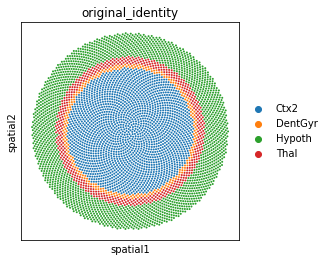

In [11]:
sc.pl.spatial(zeisel_adata, spot_size=0.02, color='original_identity')

## Mapping single cell data onto spatial data using novosparc

We will map a single-cell dataset from *Zeisel et al.* ([introduced in the first tutorial above](#Reconstructing-a-tissue-de-novo-with-novosparc)) *de-novo* onto a Visium adult mouse brain coronal section dataset. The Visium dataset was downloaded from here [https://www.10xgenomics.com/resources/datasets](https://www.10xgenomics.com/resources/datasets), and processed with spacemake using the visium run mode as specified [here](https://spacemake.readthedocs.io/en/latest/config.html#provided-run-mode-s).

The two datasets come from different experiments, and the underlying data is coming from mouse of different ages (the *Zeisel et al.* `single-cell` data is from adolescent mouse mostly, while Visium is from adult). As the Visium dataset comes from midbrain coronal section of an adult mouse, we first filtered the *Zeisel et al.* dataset to only contain 'Tissue' values of Thal, CA1, Hypoth, Ctx2, DentGyr, SScortex, roughly corresponding to areas in our Visium dataset.

Then, we mapped the `single-cell` data onto the `spatial` data using the [spacemake.spatial.novosparc_integration.novosparc_mapping](https://spacemake.readthedocs.io/en/latest/api/api.html#spacemake.spatial.novosparc_integration.novosparc_mapping) function.

First, lets download both the `spatial` and `single-cell` datasets.

In [12]:
!wget -nv -O zeisel_adata.h5ad.gz http://bimsbstatic.mdc-berlin.de/rajewsky/spacemake-test-data/zeisel_2018/adata.h5ad.gz
!wget -nv -O visium_adata.h5ad.gz http://bimsbstatic.mdc-berlin.de/rajewsky/spacemake-test-data/visium/adata.h5ad.gz
!unpigz *.h5ad.gz

2022-04-08 01:45:36 URL:https://bimsbstatic.mdc-berlin.de/rajewsky/spacemake-test-data/zeisel_2018/adata.h5ad.gz [434704805/434704805] -> "zeisel_adata.h5ad.gz" [1]
2022-04-08 01:45:40 URL:https://bimsbstatic.mdc-berlin.de/rajewsky/spacemake-test-data/visium/adata.h5ad.gz [149587898/149587898] -> "visium_adata.h5ad.gz" [1]


Then we load both datasets using [scanpy](https://github.com/scverse/scanpy):

In [13]:
import scanpy as sc

zeisel_adata = sc.read('zeisel_adata.h5ad')
visium_adata = sc.read('visium_adata.h5ad')

Next, we map the `single-cell` data onto the `spatial` data using the [spacemake.spatial.novosparc_integration.novosparc_mapping](https://spacemake.readthedocs.io/en/latest/api/api.html#spacemake.spatial.novosparc_integration.novosparc_mapping) function:

In [14]:
from spacemake.spatial.novosparc_integration import novosparc_mapping

tissue_reconst = novosparc_mapping(sc_adata = zeisel_adata, st_adata = visium_adata)

Setting up for reconstruction ... 

/home/tsztank/.miniconda3/envs/spacemake/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


done ( 844.22 seconds )
Reconstructing spatial information with 84 markers: 32040 cells and 2689 locations ... 
Trying with epsilon: 5.00e-03


After the mapping is done we can save the result, and visualize some neuronal marker genes for comparison:

In [16]:
reconst_adata = save_novosparc_res(tissue_reconst, zeisel_adata)

/home/tsztank/.miniconda3/envs/spacemake/lib/python3.9/site-packages/spacemake/spatial/novosparc_integration.py:247: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_reconst = anndata.AnnData(


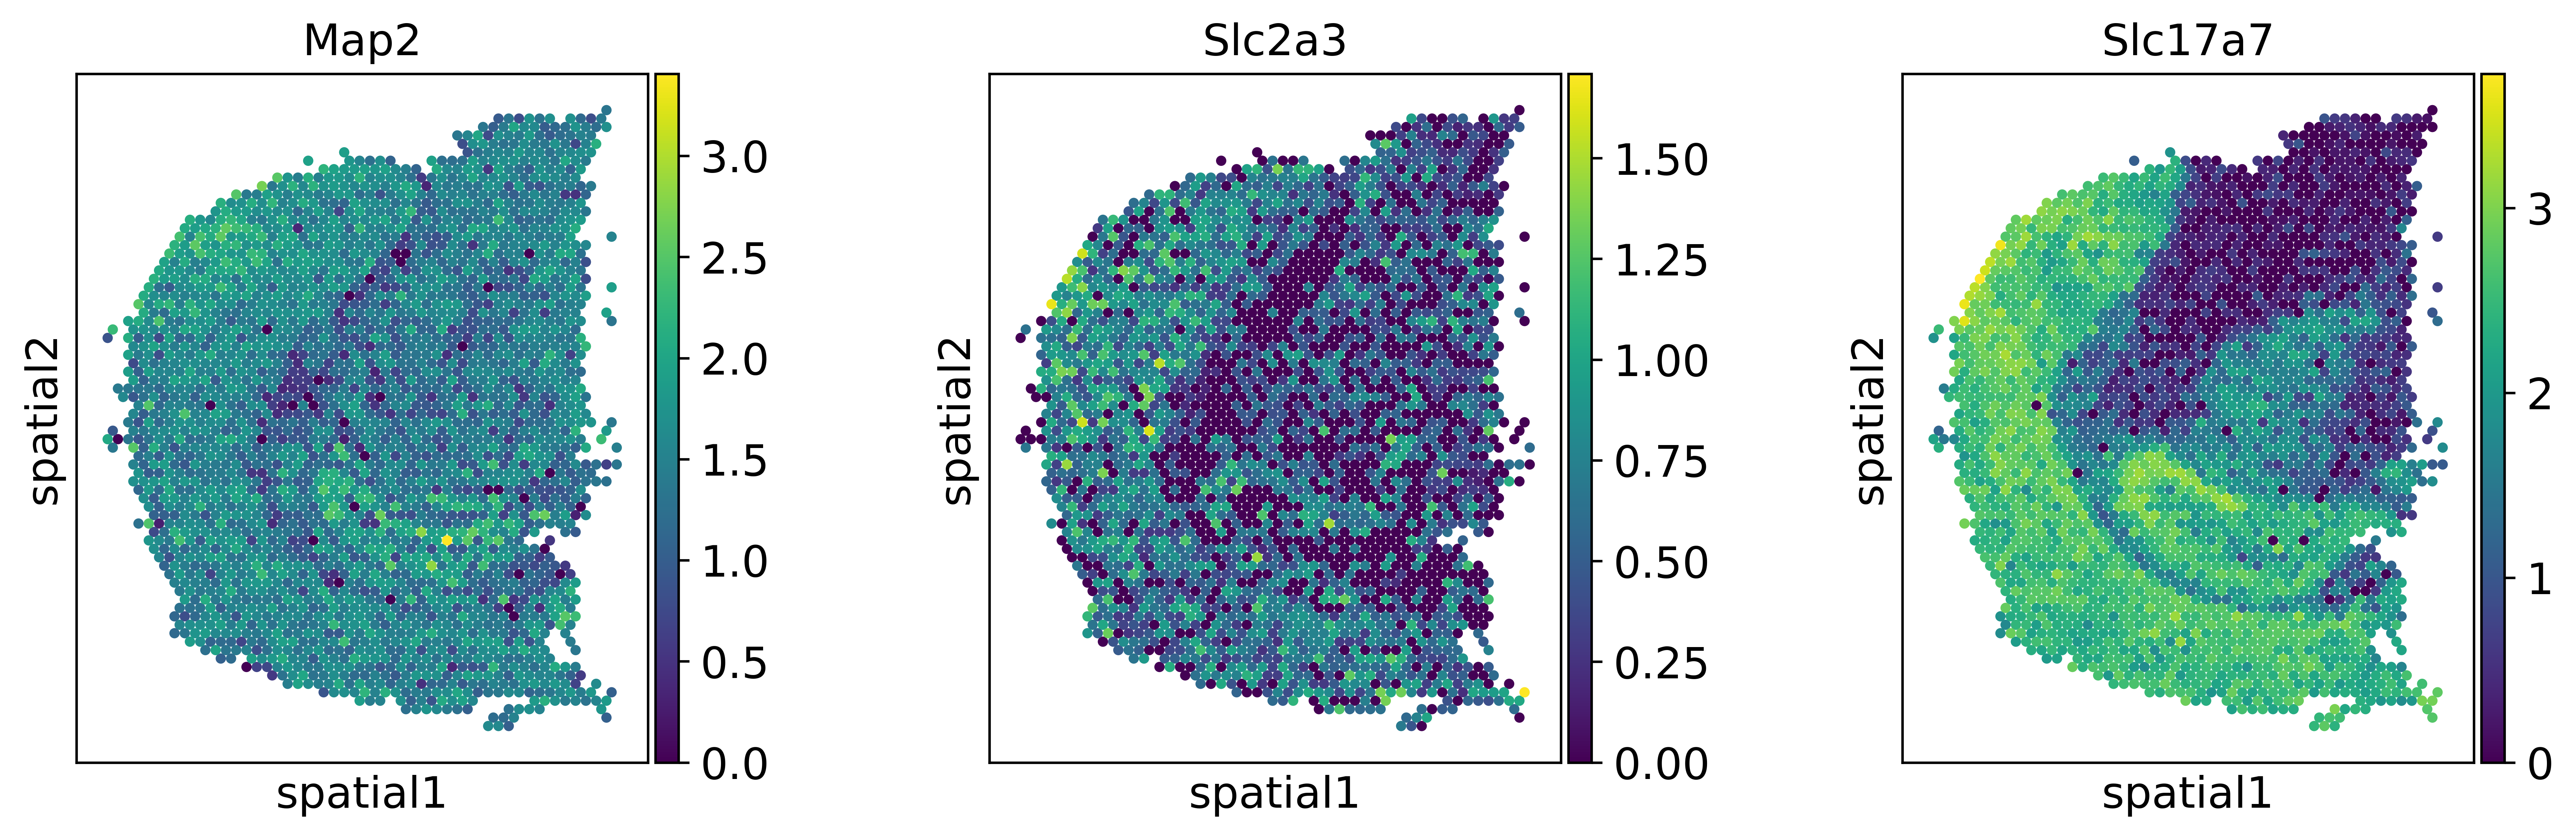

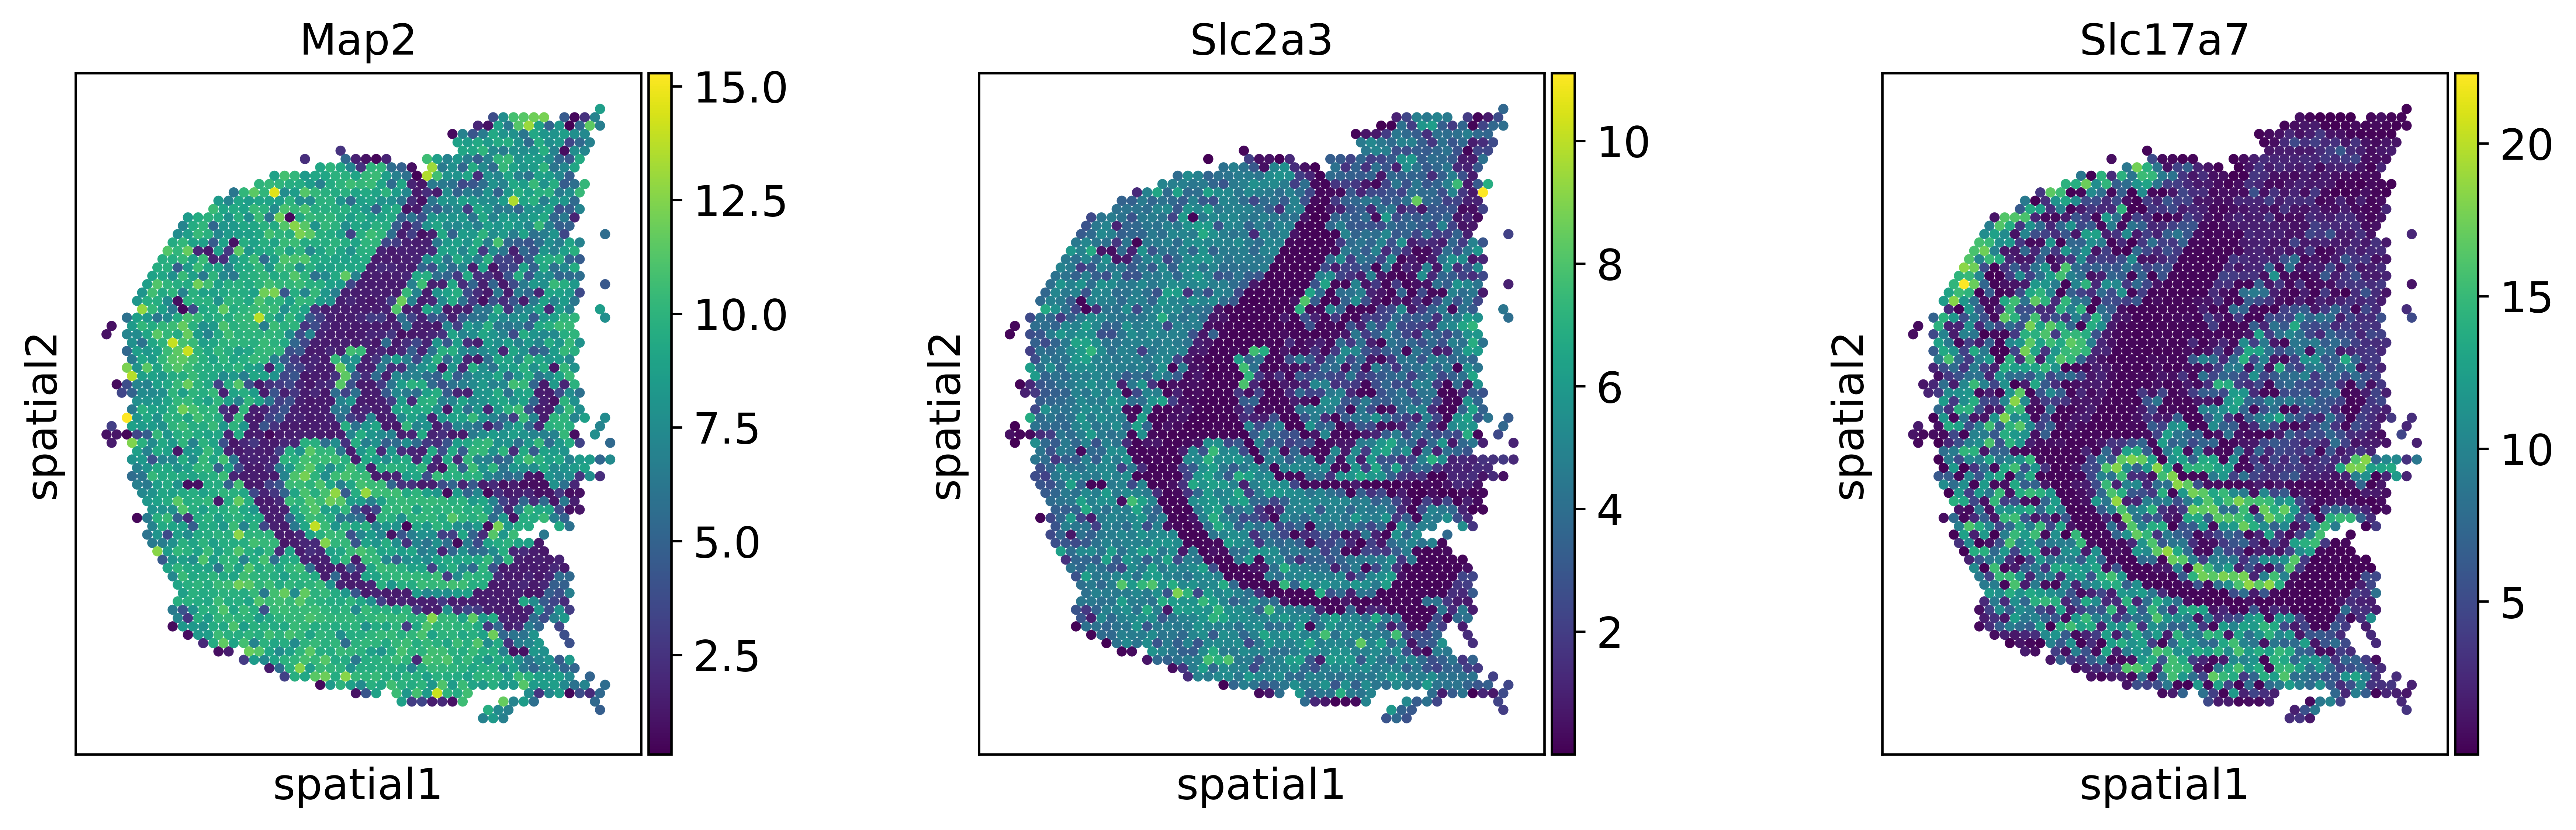

In [20]:
sc.set_figure_params(dpi=300)

genes = ['Map2','Slc2a3','Slc17a7']

sc.pl.spatial(visium_adata, color=genes, spot_size = 2, use_raw=False)
sc.pl.spatial(adata_reconst, color=genes, spot_size = 2, use_raw=False)

We can observe, that the expression patterns of these genes are different for the original dataset (top row) and after mapping the `single-cell` data onto the `spatial` data with novosparc (bottom row). 

After mapping the expression becomes more specific in space, as if the data was smoothed. 

Now, one can use the reconstructed dataset and analyze it separately: cluster the data, identify markers, etc.

*Note*: the scale-bars between top and bottom rows are not directly comparable. In the top-row we have a log-normalized expression value, in the bottom we have probabilities coming from novosparc's optimal transport approach, scaled so that both datasets have equal expression.